In [1]:
# Install required libraries
!pip install -q nltk scikit-learn pandas matplotlib seaborn gradio transformers datasets accelerate sentencepiece

In [2]:
import os
import re
import json
import pickle
from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# NLTK for preprocessing
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

print('Imports ready.')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Imports ready.


In [3]:
# to clean the text and remove any unwanted words
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    words = text.split()
    words = [w for w in words if w not in STOPWORDS and len(w) > 1]
    words = [lemmatizer.lemmatize(w) for w in words]
    return ' '.join(words)

# quick test
print(clean_text("This is AMAZING!! Check http://x.com \n New-line."))


amazing check new line


In [4]:
# Option A: If running in Colab, upload a CSV using the widget.
# Option B: If you already uploaded 'combined_dataset.csv' to the notebook environment, we'll load it.

DATA_PATH = '/content/drive/MyDrive/Assignment-j/combined_dataset.csv'  # fallback filename

if os.path.exists('/content/drive/MyDrive/Assignment-j/combined_dataset.csv'):
    df = pd.read_csv('/content/drive/MyDrive/Assignment-j/combined_dataset.csv')
    print('Loaded /content/combined_dataset.csv')
else:
    print('No local combined_dataset.csv found. Please upload your dataset file using the next cell.')
    df = None

# If df is loaded, show sample
if isinstance(df, pd.DataFrame):
    print('Dataset shape:', df.shape)
    display(df.head(5))

No local combined_dataset.csv found. Please upload your dataset file using the next cell.


In [5]:

# If you don't have a local file, run this cell in Colab to upload from your machine.
from google.colab import files
uploaded = files.upload() if 'google.colab' in str(get_ipython()) else {}
for fn in uploaded.keys():
    print('Uploaded', fn)
    df = pd.read_csv(fn)
print('Dataset shape:', df.shape)
df.head()

Saving combined_dataset.csv to combined_dataset.csv
Uploaded combined_dataset.csv
Dataset shape: (133, 2)


,comment,category
0,"Amazing work, this looks beautiful!",Praise
1,"Fantastic job, truly impressive!",Praise
2,Great animation quality!,Praise
3,"This design is perfect, love it!",Praise
4,Your editing skills are outstanding!,Praise


Preprocessing done. Sample:


,comment,clean,category
0,"Amazing work, this looks beautiful!",amazing work look beautiful,Praise
1,"Fantastic job, truly impressive!",fantastic job truly impressive,Praise
2,Great animation quality!,great animation quality,Praise
3,"This design is perfect, love it!",design perfect love,Praise
4,Your editing skills are outstanding!,editing skill outstanding,Praise
5,"Wow, stunning visuals!",wow stunning visuals,Praise
6,Absolutely loved this!,absolutely loved,Praise
7,"Perfect execution, well done!",perfect execution well done,Praise


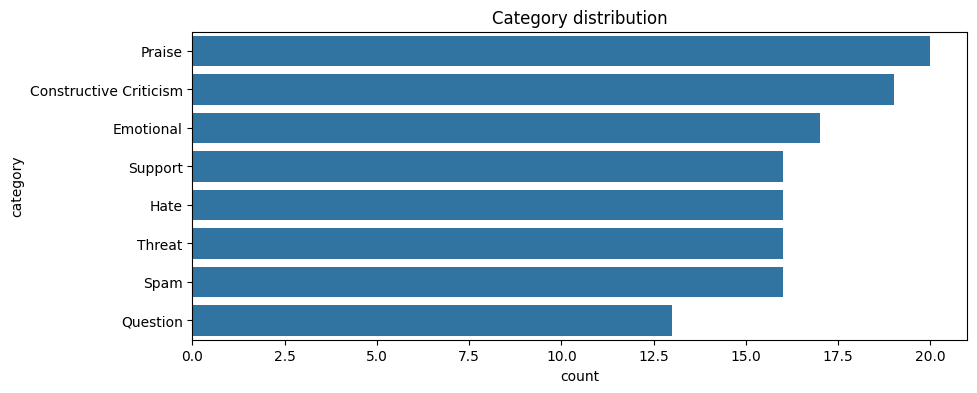

In [6]:
# Ensure 'comment' and 'category' columns exist.
required_cols = ['comment','category']
if df is None:
    raise ValueError('No dataset loaded. Upload combined_dataset.csv or another labeled CSV with columns: comment,category')
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"Dataset missing required column: {c}")

# Clean text
df['clean'] = df['comment'].apply(clean_text)
print('Preprocessing done. Sample:')
display(df[['comment','clean','category']].head(8))

# Show distribution
plt.figure(figsize=(10,4))
sns.countplot(y='category', data=df, order=df['category'].value_counts().index)
plt.title('Category distribution')
plt.show()

Training complete.
                        precision    recall  f1-score   support

Constructive Criticism       0.33      0.25      0.29         4
             Emotional       1.00      0.75      0.86         4
                  Hate       0.00      0.00      0.00         3
                Praise       0.15      0.50      0.24         4
              Question       0.00      0.00      0.00         3
                  Spam       1.00      1.00      1.00         3
               Support       0.00      0.00      0.00         3
                Threat       1.00      1.00      1.00         3

              accuracy                           0.44        27
             macro avg       0.44      0.44      0.42        27
          weighted avg       0.44      0.44      0.43        27



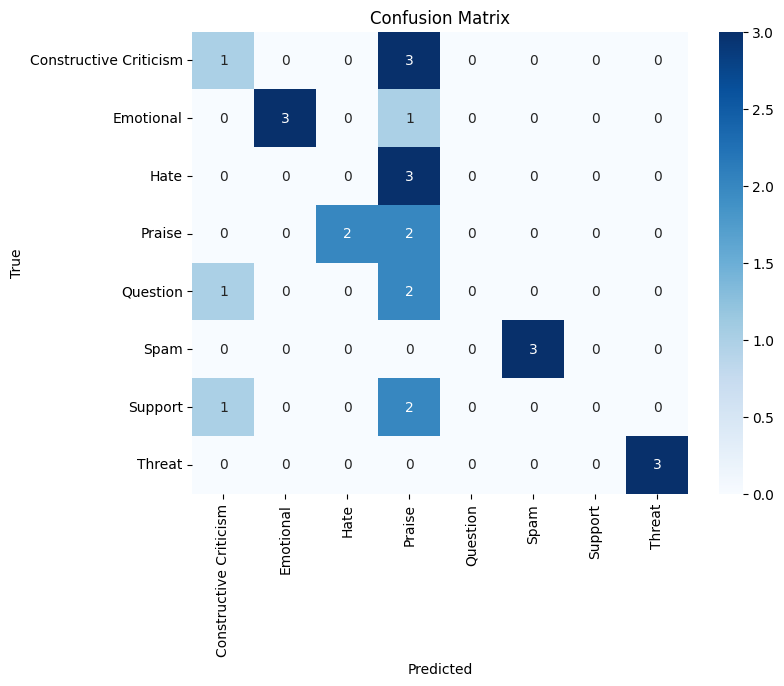

In [7]:
#TRAINING
# Prepare data
X = df['clean'].fillna('')
y = df['category']

# Split (stratify if possible)
try:
    X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
except Exception as e:
    X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

# Train model
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)
print('Training complete.')

# Evaluate
preds = clf.predict(X_test)
print(classification_report(y_test, preds, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_test, preds, labels=clf.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=clf.classes_, yticklabels=clf.classes_, cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()

In [11]:
# Save artifacts
Path('artifacts').mkdir(parents=True, exist_ok=True)
with open('artifacts/vectorizer.pkl','wb') as f:
    pickle.dump(vectorizer, f)
with open('artifacts/model.pkl','wb') as f:
    pickle.dump(clf, f)

# Reply templates
reply_templates = {
    "Praise":"Thank you so much! We’re glad you enjoyed it 😊",
    "Support":"Your support means a lot to us — thank you!",
    "Constructive Criticism":"Thanks for your feedback. We'll work on improving this.",
    "Hate":"We're sorry you feel this way. Can you tell us what went wrong?",
    "Threat":"We take safety seriously. We've recorded this and will escalate as needed.",
    "Emotional":"Thank you for sharing — your words matter to us.",
    "Spam":"This comment was flagged as promotional/spam and filtered.",
    "Question":"Thanks for your question. We'll reply with details soon."
}

with open('artifacts/reply_templates.json','w') as f:
    json.dump(reply_templates, f, indent=2)

print('Saved model, vectorizer, and reply templates to /content/artifacts/')


Saved model, vectorizer, and reply templates to /content/artifacts/


In [9]:
#ONLY EXAMPLES
def classify_comments(comments:list):
    cleaned = [clean_text(c) for c in comments]
    vec = vectorizer.transform(cleaned)
    preds = clf.predict(vec)
    return preds

# Example batch classify and export
sample_comments = [
    'Amazing work, loved it!',
    'I will report you if you continue.',
    'Try improving the audio next time.'
]
print('Examples:', sample_comments)
print('Predictions:', classify_comments(sample_comments))

# Function to categorize an uploaded CSV and export categorized file
def categorize_file(input_csv, output_csv='categorized_output.csv'):
    df_in = pd.read_csv(input_csv)
    if 'comment' not in df_in.columns:
        raise ValueError('Input CSV must have a "comment" column.')
    df_in['clean'] = df_in['comment'].astype(str).apply(clean_text)
    df_in['predicted_category'] = classify_comments(df_in['comment'].tolist())
    df_in.to_csv(output_csv, index=False)
    print('Saved categorized file to', output_csv)
    return output_csv


Examples: ['Amazing work, loved it!', 'I will report you if you continue.', 'Try improving the audio next time.']
Predictions: ['Praise' 'Threat' 'Constructive Criticism']


In [10]:
#GRADIO UI


import gradio as gr
import pandas as pd

# --- CLASSIFIER FUNCTION ---
def classify_comment(comment):
    pred = classify_comments([comment])[0]
    reply = reply_templates.get(pred, "")
    return pred, reply

# --- FILE CLASSIFIER FUNCTION ---
def classify_file(file):
    df_in = pd.read_csv(file.name)
    if "comment" not in df_in.columns:
        return None, "❌ Error: CSV must contain a 'comment' column.", None

    df_in["predicted_category"] = classify_comments(df_in["comment"].tolist())

    # Sort categories
    df_sorted = df_in.sort_values("predicted_category")

    # Save export file
    export_path = "/content/categorized_output.csv"
    df_sorted.to_csv(export_path, index=False)

    return df_sorted, "✔ File processed successfully!", export_path

# --- GRADIO APP ---
with gr.Blocks(title="Comment Categorization Tool") as app:

    gr.Markdown("""
    # 🧠 Comment Categorization & Reply Assistant
    Upload a CSV or type a comment to classify it into:
    **Praise, Support, Constructive Criticism, Hate, Threat, Emotional, Spam, Question**
    """)

    with gr.Tab("🔤 Single Comment"):
        comment_input = gr.Textbox(label="Enter a comment")
        category_output = gr.Label(label="Predicted Category")
        reply_output = gr.Textbox(label="Suggested Reply")
        analyze_btn = gr.Button("Classify")

        analyze_btn.click(
            classify_comment,
            inputs=comment_input,
            outputs=[category_output, reply_output]
        )

    with gr.Tab("📄 CSV File"):
        file_input = gr.File(label="Upload CSV with a 'comment' column")
        processed_table = gr.Dataframe(label="Categorized Output")
        file_status = gr.Textbox(label="Status")
        download_button = gr.File(label="Download Categorized CSV")

        process_btn = gr.Button("Process File")

        process_btn.click(
            classify_file,
            inputs=file_input,
            outputs=[processed_table, file_status, download_button]
        )

app.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b9db9a80b5b2f5e0e1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
